In [2]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Replace with the GPU index you want to use

# Confirm the selected GPU
print(f"Using GPU {os.environ['CUDA_VISIBLE_DEVICES']} for the experiment.")

Using GPU 1 for the experiment.


In [3]:
#imports
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy
import seaborn as sns
import math
import json
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

2024-01-07 17:17:01.661257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(tf.__version__)

2.13.0


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Print the list of available GPUs
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPU available.")

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
#Prepare Training Data:
path_to_X = "../Normalised/X.npy"
path_to_Y = "../Normalised/Y.npy"
X = np.load(path_to_X)
Y = np.load(path_to_Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
print(len(X_train))
print(len(X_test))
# Reshape the input and output data for the encoder and decoder
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # (No of Data, 50) to (No of data, 50,1)
print("X_train_reshaped shape: ", X_train_reshaped.shape)
Y_train_reshaped = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
print("Y_train_resahped shape: ", Y_train_reshaped.shape)
# Define the input shape for the encoder
input_shape = X_train_reshaped.shape[1:]  # Shape: (sequence_length, 1) # 50,1
print("Input_shape: ", input_shape)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test_reshaped = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)
print("X_test_reshaped",X_test_reshaped.shape)
print("Y_test_reshaped",Y_test_reshaped.shape)

49730
12433
X_train_reshaped shape:  (49730, 50, 1)
Y_train_resahped shape:  (49730, 81, 1)
Input_shape:  (50, 1)
X_test_reshaped (12433, 50, 1)
Y_test_reshaped (12433, 81, 1)


In [7]:
# Define the model
def createModel(units, optimizer):        
    # Define the encoder
    encoder_inputs = Input(shape=input_shape)
    encoder_lstm = LSTM(units)(encoder_inputs)
    encoder_model = Model(encoder_inputs, encoder_lstm)
    
    # Define the input shape for the decoder (with 40 units to match encoder LSTM units)
    decoder_inputs = Input(shape=(units,))  # This will serve as the initial state of the decoder LSTM
    decoder_lstm = LSTM(units, return_sequences=True)(RepeatVector(Y_train_reshaped.shape[1])(decoder_inputs))
    decoder_outputs = Dense(1, activation='sigmoid')(decoder_lstm)
    
    # Define the decoder model
    decoder_model = Model(decoder_inputs, decoder_outputs)
    
    # Create the full seq_model model
    seq_model_outputs = decoder_model(encoder_lstm)
    seq_model = Model(encoder_inputs, seq_model_outputs)
    
    # Compile the model
    seq_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics = ['mae'])
    
    # Display the model summary
    seq_model.summary()
    return seq_model

In [8]:
#Train the model
tf.debugging.set_log_device_placement(False)

# Verify the available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs:", gpus)
if gpus:
    # Use the first GPU for training
    with tf.device('/GPU:1'):
        seq_model = createModel(40,'adam')
        save_path = "./Saved_Models_Data/P30_U40_OA/"
        early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
        mc = ModelCheckpoint(save_path+"best_enc_dec_3.h5", monitor = 'val_loss',mode='min', save_best_only=True, verbose=1)
        history = seq_model.fit(X_train_reshaped, Y_train_reshaped, batch_size=32, epochs=200, validation_split=0.2, callbacks=[early_stopping, mc])
        with open(save_path+'history_3.json','w') as file:
            json.dump(history.history, file)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-07 17:17:33.792998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78946 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:25:00.0, compute capability: 8.0


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 model_1 (Functional)        (None, 81, 1)             13001     
                                                                 
Total params: 19721 (77.04 KB)
Trainable params: 19721 (77.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


2024-01-07 17:17:38.180411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-07 17:17:38.319417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-07 17:17:38.319792: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f072400c4f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-07 17:17:38.319810: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-01-07 17:17:38.324186: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-07 17:17:38.447247: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

1240/1244 [============================>.] - ETA: 0s - loss: 0.1127 - mae: 0.2324
Epoch 1: val_loss improved from inf to 0.09147, saving model to ./Saved_Models_Data/P30_U40_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 18s 12ms/step - loss: 0.1126 - mae: 0.2323 - val_loss: 0.0915 - val_mae: 0.1985
Epoch 2/200
  16/1244 [..............................] - ETA: 13s - loss: 0.0922 - mae: 0.1969

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1240/1244 [============================>.] - ETA: 0s - loss: 0.0838 - mae: 0.1725
Epoch 2: val_loss improved from 0.09147 to 0.08192, saving model to ./Saved_Models_Data/P30_U40_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 14s 11ms/step - loss: 0.0838 - mae: 0.1725 - val_loss: 0.0819 - val_mae: 0.1582
Epoch 3/200
1244/1244 [==============================] - ETA: 0s - loss: 0.0770 - mae: 0.1515
Epoch 3: val_loss improved from 0.08192 to 0.07458, saving model to ./Saved_Models_Data/P30_U40_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 14s 12ms/step - loss: 0.0770 - mae: 0.1515 - val_loss: 0.0746 - val_mae: 0.1457
Epoch 4/200
1244/1244 [==============================] - ETA: 0s - loss: 0.0733 - mae: 0.1434
Epoch 4: val_loss improved from 0.07458 to 0.07212, saving model to ./Saved_Models_Data/P30_U40_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 14s 12ms/step - loss: 0.0733 - mae: 0.1434 - val_loss: 0.0721 - val_mae: 0.1403
Epoc

In [9]:
import numpy as np
import json
import matplotlib.pyplot as plt
save_path = "./Saved_Models_Data/P30_U40_OA/"

f = open(save_path+"history_3.json")
history = json.load(f)

print(len(history['loss']))


70


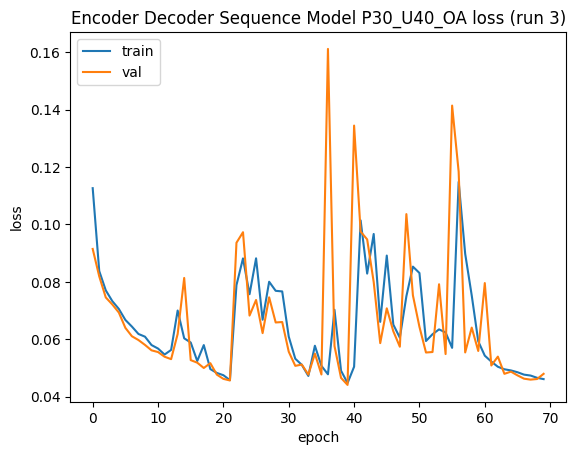

In [10]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Encoder Decoder Sequence Model P30_U40_OA loss (run 3)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
#Evaluate the saved best model:
from tensorflow.keras.models import load_model
saved_model = load_model("./Saved_Models_Data/P30_U40_OA/best_enc_dec_3.h5")
best_eval = saved_model.evaluate(X_test_reshaped, Y_test_reshaped)

print("Mean Squared Error: ", best_eval[0])
print("Mean Absolute Error: ", best_eval[1])

#RMSE:
mse_value = best_eval[0]
rmse_value = np.sqrt(mse_value)
print("Root Mean Squared Error (RMSE): ", rmse_value)

389/389 [==============================] - 3s 5ms/step - loss: 0.0444 - mae: 0.0853
Mean Squared Error:  0.0444168820977211
Mean Absolute Error:  0.0853431224822998
Root Mean Squared Error (RMSE):  0.21075313069494625


In [12]:
save_path = "./Saved_Models_Data/P30_U40_OA/"

In [13]:
#Save the predictions
predictions = saved_model.predict(X_test_reshaped)
original_shape_predictions = predictions.reshape(X_test.shape[0], Y_test.shape[1])
np.save(save_path+"predictions_3.npy",original_shape_predictions)

#Save the ground truth:
np.save(save_path+"ground-truth_3.npy", Y_test)

389/389 [==============================] - 2s 4ms/step


In [14]:
save_path = "./Saved_Models_Data/P30_U40_OA/"

In [15]:
#Load the ground truth and predictions:
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path +"ground-truth_3.npy")

print(y_pred.shape)
print(y_true.shape)
#Print some samples:
for sample in range(5):
    print(f"SAMPLE: {sample}")
    for i in range (81):
        print(f"Index {i} Ground truth: {y_true[sample][i]} Predicted: {y_pred[sample][i]}")

(12433, 81)
(12433, 81)
SAMPLE: 0
Index 0 Ground truth: 0 Predicted: 0.11969607323408127
Index 1 Ground truth: 0 Predicted: 0.30747339129447937
Index 2 Ground truth: 1 Predicted: 0.7369004487991333
Index 3 Ground truth: 0 Predicted: 0.008010008372366428
Index 4 Ground truth: 0 Predicted: 0.0012269491562619805
Index 5 Ground truth: 0 Predicted: 0.009236768819391727
Index 6 Ground truth: 0 Predicted: 0.0010507861152291298
Index 7 Ground truth: 0 Predicted: 0.0007999539957381785
Index 8 Ground truth: 0 Predicted: 0.0004675276577472687
Index 9 Ground truth: 0 Predicted: 1.1488689779071137e-05
Index 10 Ground truth: 0 Predicted: 2.54810402111616e-06
Index 11 Ground truth: 0 Predicted: 5.531704118766356e-06
Index 12 Ground truth: 0 Predicted: 0.0014371598372235894
Index 13 Ground truth: 1 Predicted: 0.9646010994911194
Index 14 Ground truth: 0 Predicted: 0.043012458831071854
Index 15 Ground truth: 0 Predicted: 0.0005199591396376491
Index 16 Ground truth: 0 Predicted: 8.667931979289278e-05
Ind

In [16]:
#Can convert to Benesh version for predictions using a threshold here = 0.5
print("Converting the predictions to benesh versions:")
benesh_arr = np.zeros_like(y_pred)

for sample in range(len(y_pred)):
  #print(f"SAMPLE: {sample}")
  for i in range (81):
    # can add more logic here to change the thresholds for specific indices.
    if y_pred[sample][i] >= 0.5:
      benesh_arr[sample][i] = 1
    elif y_pred[sample][i] < 0.5:
      benesh_arr[sample][i]= 0

print(benesh_arr[:2])
np.save(save_path+"y_pred_benesh_3.npy", benesh_arr)

Converting the predictions to benesh versions:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]]


In [17]:
#save the error array
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path+"ground-truth_3.npy")

err_arr = np.zeros((12433,81))

for r in range(len(y_pred)):
    for c in range(81):
        err_arr[r][c] = abs(y_true[r][c]-y_pred[r][c])
        
np.save(save_path+"err_arr_3.npy",err_arr)

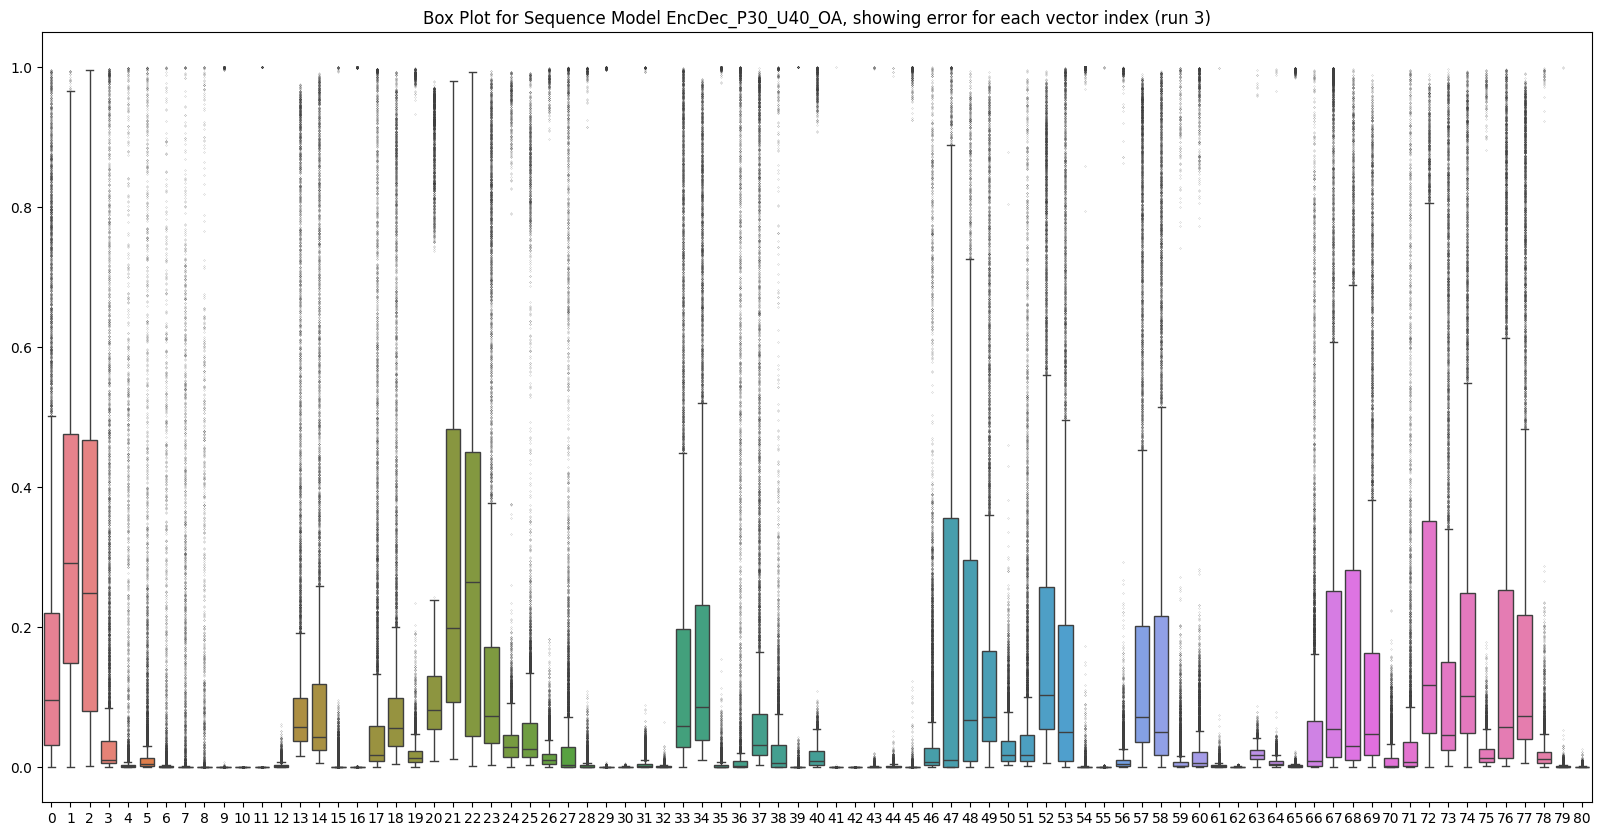

In [18]:
import seaborn as sns
err_arr = np.load(save_path+"err_arr_3.npy")
#fig, ax = plt.subplots(figsize=(18, 9))
plt.figure(figsize = (20,10))
sns.boxplot(err_arr, fliersize = 0.1 ,gap=0.05).set(title='Box Plot for Sequence Model EncDec_P30_U40_OA, showing error for each vector index (run 3)')
plt.show()

In [19]:
#Calculate MAPE
def mean_abs_perc_err(gt_arr, pred_arr, num_samples, vec_size):
    err_arr = np.zeros((num_samples,vec_size))
    print("Calculating MAPE")
    for r in range(len(pred_arr)):
        for c in range(vec_size):
          err_arr[r][c] = abs(gt_arr[r][c]-pred_arr[r][c]) # Calculation of the percentage error
    per_sample_mape_arr = np.sum(err_arr,axis=1)/vec_size
    print(per_sample_mape_arr.shape)
    print("MAPE for 10 samples...",per_sample_mape_arr[:10])
    overall_MAPE = sum(per_sample_mape_arr)/num_samples
    print("OVERALL MAPE: ", overall_MAPE*100)

n_samples = 12433
v_size = 81
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path+"ground-truth_3.npy")
mean_abs_perc_err(y_true,y_pred,n_samples,v_size)

Calculating MAPE
(12433,)
MAPE for 10 samples... [0.05537285 0.0625281  0.04245951 0.08737482 0.11479792 0.07359909
 0.15337124 0.13922812 0.10633032 0.06851845]
OVERALL MAPE:  8.534312452739039


In [20]:
from sklearn.metrics import r2_score

In [21]:
#Calculate R2 Score:
result_r2 = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the R-squared value for each row
    r2 = r2_score(y_true[i, :], y_pred[i, :])
    result_r2[i] = r2

print("R-squared value for each row (sample):", result_r2)
# Calculate the overall R-squared value
overall_r2 = np.mean(result_r2)

# Print the overall R-squared value
print("Overall R-squared value:", overall_r2)

R-squared value for each row (sample): [0.84432584 0.78331194 0.91009129 ... 0.82479367 0.55945912 0.77333722]
Overall R-squared value: 0.6480446108145527


In [22]:
#Spearman Correlation:
result = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Spearman correlation for each row
    row_result = scipy.stats.spearmanr(y_true[i, :], y_pred[i, :])

    # Checking for zero standard deviation
    if np.isnan(row_result.correlation) or np.isnan(row_result.pvalue):
        # Handle the case where the result contains NaN
        result[i] = 0  # Set the correlation coefficient to 0
    else:
        result[i] = row_result.correlation

print("Spearman correlation coefficients for each row (sample):", result)
overall_spearman_corr = np.mean(result)

# Print the overall Spearman correlation coefficient
print("Overall Spearman correlation coefficient:", overall_spearman_corr)

Spearman correlation coefficients for each row (sample): [0.61089329 0.6034615  0.61386601 ... 0.61237965 0.51279364 0.52765722]
Overall Spearman correlation coefficient: 0.559575493558749


In [23]:
#Pearson Correlation:
result_pearson = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Pearson correlation for each row
    corr_matrix = np.corrcoef(y_true[i, :], y_pred[i, :])
    result_pearson[i] = corr_matrix[0, 1]

# Calculate the overall Pearson correlation coefficient
overall_pearson_corr = np.mean(result_pearson)

print("Pearson correlation coefficients for each row:", result_pearson)
print(len(result_pearson))
# Print the overall Pearson correlation coefficient
print("Overall Pearson correlation coefficient:", overall_pearson_corr)

Pearson correlation coefficients for each row: [0.92223869 0.88586403 0.95796598 ... 0.91435063 0.74831099 0.88079398]
12433
Overall Pearson correlation coefficient: 0.8033501349996923


In [24]:
from sklearn.metrics import matthews_corrcoef
y_pred_b = np.load(save_path + "y_pred_benesh_3.npy")
y_true = np.load(save_path + "ground-truth_3.npy")

result_mcc = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Matthews Correlation Coefficient for each row
    mcc = matthews_corrcoef(y_true[i, :], y_pred_b[i, :])
    result_mcc[i] = mcc

# Calculate the overall Matthews Correlation Coefficient
overall_mcc = np.mean(result_mcc)

# Print the overall Matthews Correlation Coefficient
print("Overall Matthews Correlation Coefficient:", overall_mcc)

Overall Matthews Correlation Coefficient: 0.7571106097879342


In [25]:
#Save boxplot stats
import numpy as np
save_path = "./Saved_Models_Data/P30_U40_OA/"

np.set_printoptions(suppress=True) # Disable scientific notation
filename = "err_arr_3.npy"

err = np.load(save_path+filename)
print(len(err))

stats = np.empty(shape = (0,5))
n_indices = len(err[0]) # should be 81
print(n_indices)

for i in range(n_indices):
    i_stats = np.percentile(err[:, i], [0, 25, 50, 75, 100]) # = [Min, Q1, Med, Q3, Max]
    stats = np.vstack([stats, i_stats]) # Add row to numpy stats object 
    print("index: {}".format(i), i_stats)

# print(stats)
out_filename = "boxplot_stats_3.csv"

np.savetxt(save_path+out_filename, stats, delimiter = ',', fmt='%f')

12433
81
index: 0 [0.00071466 0.03217567 0.09661599 0.22012702 0.99633073]
index: 1 [0.00079382 0.14936891 0.29190847 0.47648025 0.99520881]
index: 2 [0.00223937 0.08063543 0.24923629 0.4679113  0.99586264]
index: 3 [0.00049848 0.0059279  0.01108779 0.03746176 0.99772766]
index: 4 [0.00009822 0.00067707 0.00144074 0.0036903  0.99958612]
index: 5 [0.00005952 0.00180721 0.0047101  0.01334225 0.99981255]
index: 6 [0.00001599 0.0003185  0.00066069 0.00122909 0.99994413]
index: 7 [0.00001862 0.00013713 0.00028476 0.00059465 0.99994176]
index: 8 [0.00001303 0.00005756 0.00012676 0.00030519 0.99995025]
index: 9 [0.00000272 0.00000714 0.00001044 0.00001624 0.9999916 ]
index: 10 [0.0000014  0.00000247 0.00000295 0.00000382 0.00012861]
index: 11 [0.00000229 0.00000532 0.00000725 0.00001036 0.9999908 ]
index: 12 [0.00008736 0.00103163 0.0020247  0.00372734 0.06173764]
index: 13 [0.01660734 0.03822744 0.05693167 0.09947067 0.97609532]
index: 14 [0.00591611 0.02444474 0.04255564 0.11835343 0.991927